# US Census Demographic Data Analysis

Date: 10/30/2025

Team Members:
- Karrie Butcher
- Nicko Lomelin
- Thanh Tuan Pham

dataset: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data?resource=download

---
## 1. Data Preparation

## Load

In [ ]:
from pathlib import Path
import pandas as pd

file_path = Path.home() / "Downloads" / "acs2017_census_tract_data.csv"

# load into pandas
df = pd.read_csv(file_path)

print("Initial shape:", df.shape)
df.head()
df.info()


Initial shape: (74001, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapE

In [3]:
# Count and display missing values
missing = df.isnull().sum()
print("Columns with missing values:\n", missing[missing > 0])

# Drop rows that contain missing values
df_clean = df.dropna(how='any').reset_index(drop=True)
print(f"\nOriginal shape: {df.shape}")
print(f"After dropping missing data: {df_clean.shape}")

# Encode string/object columns
obj_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print("\nString columns found:", obj_cols)

for col in obj_cols:
    df_clean[col] = df_clean[col].astype('category').cat.codes

# Drop County 
df_final = df_clean.drop(columns=['County'], errors='ignore')

print(f"\nFinal dataset shape: {df_final.shape}")
df_final.head()


Columns with missing values:
 Hispanic            696
White               696
Black               696
Native              696
Asian               696
Pacific             696
Income             1116
IncomeErr          1116
IncomePerCap        745
IncomePerCapErr     745
Poverty             842
ChildPoverty       1110
Professional        811
Service             811
Office              811
Construction        811
Production          811
Drive               801
Carpool             801
Transit             801
Walk                801
OtherTransp         801
WorkAtHome          801
MeanCommute         946
PrivateWork         811
PublicWork          811
SelfEmployed        811
FamilyWork          811
Unemployment        810
dtype: int64

Original shape: (74001, 37)
After dropping missing data: (72718, 37)

String columns found: ['State', 'County']

Final dataset shape: (72718, 36)


,TractId,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to remove the 'County' Variable due to it being a categorical identifier. This variable does not give enough information about our target needed for prediction. It also has many unique values, if we kept it, it may conflict the predictive signal.

## Split and Balance 

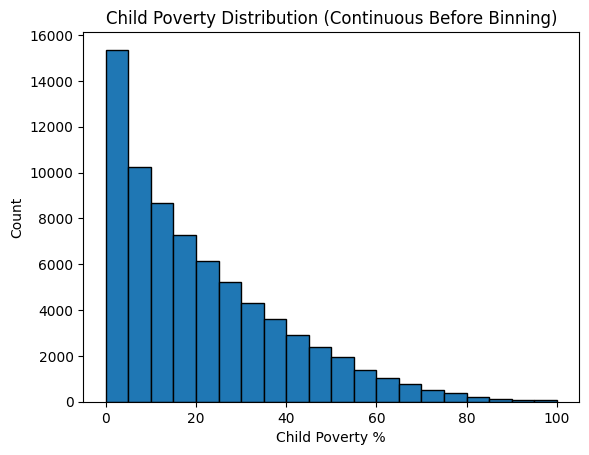

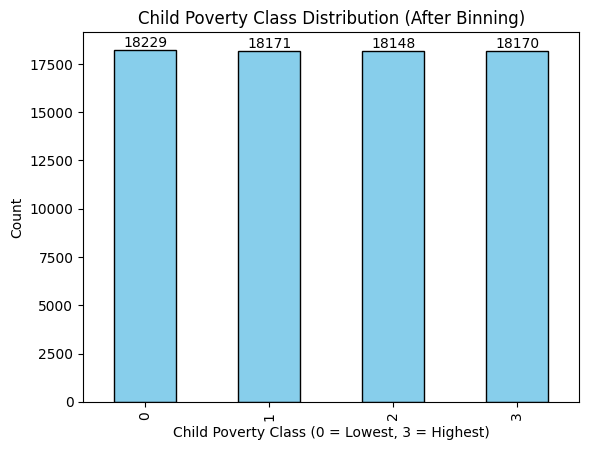

Class distribution after binning:
ChildPovertyClass
0    18229
1    18171
3    18170
2    18148
Name: count, dtype: int64


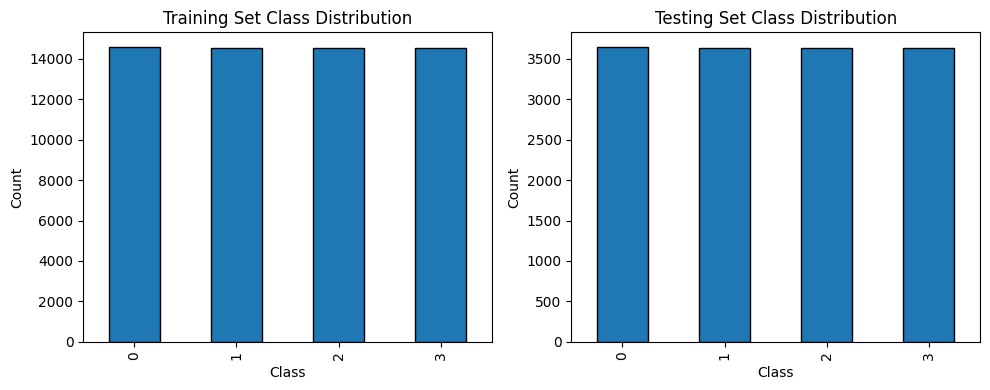


Example one-hot encoding for first 5 labels:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# BEFORE: Plot continuous distribution
plt.hist(df_final['ChildPoverty'], bins=20, edgecolor='black')
plt.title("Child Poverty Distribution (Continuous Before Binning)")
plt.xlabel("Child Poverty %")
plt.ylabel("Count")
plt.show()


# 1. Quantize to 4 equal-sized classes
df_final['ChildPovertyClass'] = pd.qcut(
    df_final['ChildPoverty'],
    q=4,
    labels=[0, 1, 2, 3]
)


# AFTER: Plot class distribution
ax = df_final['ChildPovertyClass'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.title("Child Poverty Class Distribution (After Binning)")
plt.xlabel("Child Poverty Class (0 = Lowest, 3 = Highest)")
plt.ylabel("Count")
for i, v in enumerate(df_final['ChildPovertyClass'].value_counts().sort_index()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()

print("Class distribution after binning:")
print(df_final['ChildPovertyClass'].value_counts())


# 2. Train/test split
X = df_final.drop(columns=['ChildPovertyClass'])
y = df_final['ChildPovertyClass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Plot class distribution in TRAIN and TEST
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Train
ax1 = y_train.value_counts().sort_index().plot(
    ax=axes[0], kind='bar', edgecolor='black'
)
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Test
ax2 = y_test.value_counts().sort_index().plot(
    ax=axes[1], kind='bar', edgecolor='black'
)
axes[1].set_title("Testing Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# One-hot encode the TARGET
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

print("\nExample one-hot encoding for first 5 labels:")
print(y_train_encoded[:5])


Q: Should balancing of the dataset be done for both the training and testing set? 

A: No, the balancing of the dataset should only be done for the training set. The testing set should have the original imbalanced distribution to provide a realistic outlook of the model's performance.

# 2. Pre-processing and Initial Modeling


## Model 1 (Raw features)

Training set shape: (58174, 36)
Testing set shape: (14544, 36)


Epoch 500/500, Loss: 1.392175



Training Accuracy: 0.2499
Testing Accuracy: 0.2499


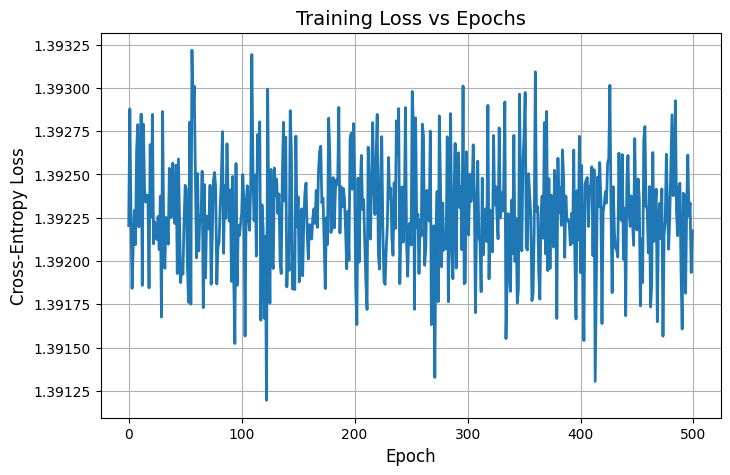

In [ ]:
# First Model: Raw Features

import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import sys


# Quantize ChildPoverty into 4 equal-sized classes
df_final['ChildPovertyClass'] = pd.qcut(
    df_final['ChildPoverty'], 
    q=4, 
    labels=[0, 1, 2, 3]
)

# Features and target
X = df_final.drop(columns=['ChildPovertyClass'])
y = df_final['ChildPovertyClass']

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

print("Training set shape:", X_train_np.shape)
print("Testing set shape:", X_test_np.shape)


# Two-Layer Perceptron Classes 

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        W1 = np.random.randn(self.n_hidden, self.n_features_) * np.sqrt(2.0 / self.n_features_)
        b1 = np.zeros((self.n_hidden, 1))
        W2 = np.random.randn(self.n_output_, self.n_hidden) * np.sqrt(2.0 / self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        return (lambda_ / 2) * (np.sum(W1**2) + np.sum(W2**2))
    
    def _cost(self, A3, Y_enc, W1, W2):
        n_samples = Y_enc.shape[1]
        A3_clipped = np.clip(A3, 1e-10, 1 - 1e-10)
        cross_entropy = -np.sum(Y_enc * np.log(A3_clipped)) / n_samples
        l2_penalty = self._L2_reg(self.l2_C, W1, W2) / n_samples
        return cross_entropy + l2_penalty

class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._softmax(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        raise NotImplementedError("Use subclass with vectorized gradient.")
    
    def fit(self, X, y, print_progress=False):
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        
        for i in range(self.epochs):
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data, self.W1, self.W2, self.b1, self.b2)
            cost = self._cost(A3, Y_enc, self.W1, self.W2)
            self.cost_.append(cost)
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                A1, A2, A3, Z1, Z2, Y_enc, self.W1, self.W2
            )
            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
        
        return self
    
    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        return np.argmax(A3, axis=0)

class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        n_samples = Y_enc.shape[1]
        dZ2 = A3 - Y_enc
        dA2 = W2.T @ dZ2
        dZ1 = dA2 * A2 * (1 - A2)
        gradW2 = (dZ2 @ A2.T) / n_samples + (self.l2_C / n_samples) * W2
        gradb2 = np.sum(dZ2, axis=1, keepdims=True) / n_samples
        gradW1 = (dZ1 @ A1.T) / n_samples + (self.l2_C / n_samples) * W1
        gradb1 = np.sum(dZ1, axis=1, keepdims=True) / n_samples
        return gradW1, gradW2, gradb1, gradb2

class TwoLayerPerceptronVectorizedMini(TwoLayerPerceptronVectorized):
    def fit(self, X, y, batch_size=512, print_progress=False):
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        self.cost_ = []
        
        n_samples = X_data.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_data[indices]
            Y_shuffled = Y_enc[:, indices]
            epoch_cost = 0
            
            for batch_idx in range(n_batches):
                start = batch_idx * batch_size
                end = min(start + batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[:, start:end]
                
                A1, Z1, A2, Z2, A3 = self._feedforward(X_batch, self.W1, self.W2, self.b1, self.b2)
                batch_cost = self._cost(A3, Y_batch, self.W1, self.W2)
                epoch_cost += batch_cost * (end - start)
                
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                    A1, A2, A3, Z1, Z2, Y_batch, self.W1, self.W2
                )
                
                self.W1 -= self.eta * gradW1
                self.W2 -= self.eta * gradW2
                self.b1 -= self.eta * gradb1
                self.b2 -= self.eta * gradb2
            
            self.cost_.append(epoch_cost / n_samples)
            if print_progress and (epoch+1) % print_progress == 0:
                sys.stderr.write(f'\rEpoch {epoch+1}/{self.epochs}, Loss: {self.cost_[-1]:.6f}')
                sys.stderr.flush()
        if print_progress:
            sys.stderr.write('\n')
        return self


# 3. Train the Network 

params = dict(
    n_hidden=64,
    C=0.0001,
    epochs=500,
    eta=0.05,
    random_state=1
)

nn = TwoLayerPerceptronVectorizedMini(**params)
nn.fit(X_train_np, y_train, batch_size=64, print_progress=50)

# 4. Evaluate 

y_train_pred = nn.predict(X_train_np)
y_test_pred = nn.predict(X_test_np)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print("="*60)


# 5. Plot Loss Curve 

plt.figure(figsize=(8,5))
plt.plot(nn.cost_, linewidth=2)
plt.title("Training Loss vs Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


## Model 2 (Numeric features scaled)

Epoch 500/500, Loss: 0.020678



Training Accuracy (numeric features): 0.9976
Testing Accuracy  (numeric features): 0.9955


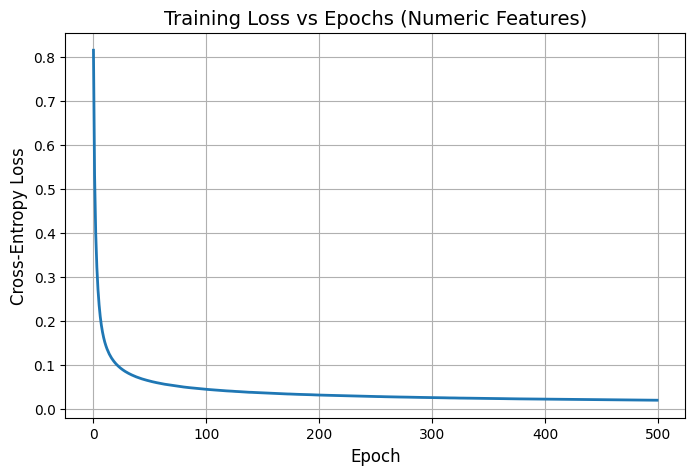

In [ ]:
# Second Model: Only Numeric Features + Normalization


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Select numeric (continuous) features
numeric_cols = X_train.select_dtypes(include=np.number).columns
X_train_num = X_train[numeric_cols].values
X_test_num = X_test[numeric_cols].values

# Normalize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

params = dict(
    n_hidden=64,     
    C=0.0001,        
    epochs=500,      
    eta=0.05,        
    random_state=1
)

# Initialize and train the network 
nn_numeric = TwoLayerPerceptronVectorizedMini(**params)
nn_numeric.fit(X_train_scaled, y_train, batch_size=64, print_progress=50)

# Predict and evaluate 
y_train_pred = nn_numeric.predict(X_train_scaled)
y_test_pred = nn_numeric.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy (numeric features): {train_acc:.4f}")
print(f"Testing Accuracy  (numeric features): {test_acc:.4f}")
print("="*60)

# Plot training loss 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(nn_numeric.cost_, linewidth=2)
plt.title("Training Loss vs Epochs (Numeric Features)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


## Model 3 (Numeric + Categorical features)

Training shape after combining numeric + categorical: (58174, 36)
Testing shape after combining numeric + categorical: (14544, 36)


Epoch 500/500, Loss: 0.020678



Training Accuracy (numeric + categorical): 0.9976
Testing Accuracy  (numeric + categorical): 0.9955


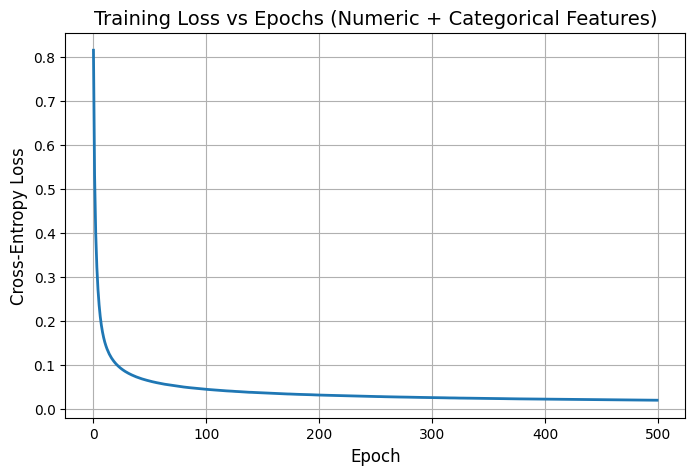

In [ ]:
# Third Model: Numeric + One-Hot Encoded Categorical Features

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# Normalize numeric features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_num_scaled = scaler.transform(X_test[numeric_cols])

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=numeric_cols, index=X_train.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=numeric_cols, index=X_test.index)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop=None)
X_train_cat_ohe = encoder.fit_transform(X_train[categorical_cols])
X_test_cat_ohe = encoder.transform(X_test[categorical_cols])

# Convert to DataFrame
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, 
                               columns=encoder.get_feature_names_out(categorical_cols), 
                               index=X_train.index)
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, 
                              columns=encoder.get_feature_names_out(categorical_cols), 
                              index=X_test.index)

# numeric + categorical features
X_train_combined = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
X_test_combined = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)

print("Training shape after combining numeric + categorical:", X_train_combined.shape)
print("Testing shape after combining numeric + categorical:", X_test_combined.shape)

params = dict(
    n_hidden=64,    # increased hidden neurons to handle more features
    C=0.0001,        # light regularization
    epochs=500,      # enough for convergence
    eta=0.05,        # learning rate
    random_state=1
)


nn_full = TwoLayerPerceptronVectorizedMini(**params)
nn_full.fit(X_train_combined.values, y_train, batch_size=64, print_progress=50)


y_train_pred = nn_full.predict(X_train_combined.values)
y_test_pred = nn_full.predict(X_test_combined.values)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print(f"Training Accuracy (numeric + categorical): {train_acc:.4f}")
print(f"Testing Accuracy  (numeric + categorical): {test_acc:.4f}")
print("="*60)


import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(nn_full.cost_, linewidth=2)
plt.title("Training Loss vs Epochs (Numeric + Categorical Features)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.grid(True)
plt.show()


# Comparison

Epoch 200/200, Loss: 1.392690
Epoch 200/200, Loss: 0.030917
Epoch 200/200, Loss: 0.030917


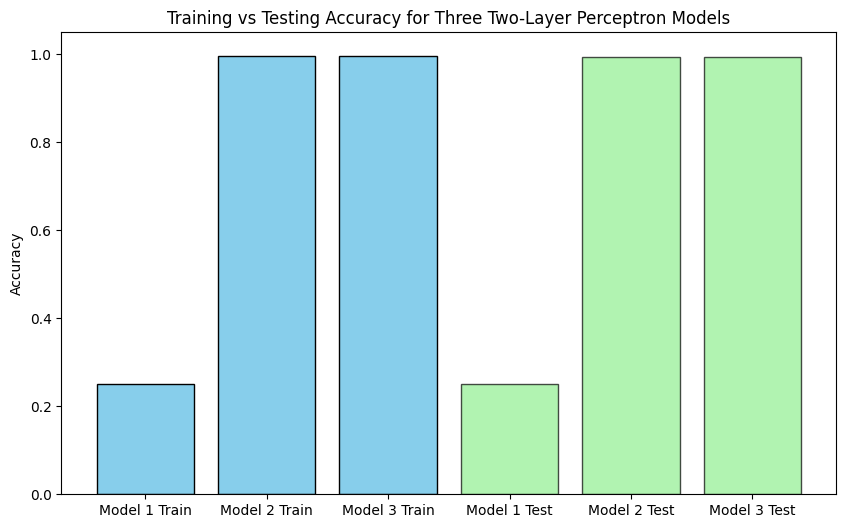

Model 1 (Raw features): Train Acc = 0.2496, Test Acc = 0.2496
Model 2 (Numeric features scaled): Train Acc = 0.9961, Test Acc = 0.9944
Model 3 (Numeric + Categorical features): Train Acc = 0.9961, Test Acc = 0.9944


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Model 1: Raw features
nn1 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn1.fit(X_train, y_train, batch_size=64, print_progress=50)

y_train_pred1 = nn1.predict(X_train.values)
y_test_pred1  = nn1.predict(X_test.values)

acc_train1 = np.mean(y_train_pred1 == y_train.values)
acc_test1  = np.mean(y_test_pred1  == y_test.values)


# 2. Model 2: Numeric only (scaled)
nn2 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn2.fit(X_train_scaled, y_train, batch_size=64, print_progress=50)

y_train_pred2 = nn2.predict(X_train_scaled)  # remove .values
y_test_pred2  = nn2.predict(X_test_scaled)   # remove .values

acc_train2 = np.mean(y_train_pred2 == y_train.values)
acc_test2  = np.mean(y_test_pred2  == y_test.values)



# 3. Model 3: Numeric + Categorical Features (scaled/one-hot)
nn3 = TwoLayerPerceptronVectorizedMini(n_hidden=64, epochs=200, eta=0.05, random_state=1)
nn3.fit(X_train_combined.values, y_train, batch_size=64, print_progress=50)

y_train_pred3 = nn3.predict(X_train_combined.values)
y_test_pred3  = nn3.predict(X_test_combined.values)

acc_train3 = np.mean(y_train_pred3 == y_train.values)
acc_test3  = np.mean(y_test_pred3  == y_test.values)



plt.figure(figsize=(10,6))
plt.bar(["Model 1 Train","Model 2 Train","Model 3 Train"], 
        [acc_train1, acc_train2, acc_train3], color='skyblue', edgecolor='black')
plt.bar(["Model 1 Test","Model 2 Test","Model 3 Test"], 
        [acc_test1, acc_test2, acc_test3], color='lightgreen', edgecolor='black', alpha=0.7)
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy for Three Two-Layer Perceptron Models")
plt.ylim(0,1.05)
plt.show()

print(f"Model 1 (Raw features): Train Acc = {acc_train1:.4f}, Test Acc = {acc_test1:.4f}")
print(f"Model 2 (Numeric features scaled): Train Acc = {acc_train2:.4f}, Test Acc = {acc_test2:.4f}")
print(f"Model 3 (Numeric + Categorical features): Train Acc = {acc_train3:.4f}, Test Acc = {acc_test3:.4f}")



Comparison (Models 1-3):

---

**Model 1 (Raw features):**

* **Performance:** ~25% accuracy on both train and test.
* **Why:** The features were not normalized or scaled, and the categorical variables were not encoded. The network struggled to learn meaningful patterns because the raw feature values could be on very different scales and non-numeric features weren’t represented properly. This caused the network to effectively **guess randomly**, which is why the accuracy is around 1/4.

**Model 2 (Numeric features scaled):**

* **Performance:** ~99.6% train, ~99.4% test.
* **Why:** Scaling the numeric features normalized their ranges, which allowed the network to **learn efficiently**. Gradient updates in the network were more balanced, so the network converged much faster and achieved 99% accuracy. 

**Model 3 (Numeric + Categorical features):**

* **Performance:** ~99.6% train, ~99.4% test (same as Model 2).
* **Why:** One-hot encoding the categorical features added more information, but in this dataset, it did not significantly improve accuracy. The numeric features were already very predictive, so adding categorical features did not change much performance. 
---